### 실습

문제 2: 고객 코호트 분석 및 유지율 개선 전략
목표: "월별 가입 코호트"의 유지율과 매출 기여도를 분석하여 고객 유지 전략을 수립하세요.
1. 코호트 그룹 생성
2. 월별 유지율 계산
    - 각 거래의 코호트 대비 경과 개월 수 계산
    - 코호트별 Month 0, 1, 2, ... 12에서의 활성 고객 수
    - 유지율 테이블 생성 (코호트 × 경과월)
    - 평균 유지율 곡선 계산
3. 코호트별 매출 기여도 분석
    - 각 코호트의 월별 누적 매출 계산
    - 코호트별 고객 1인당 누적 매출 (ARPU) 계산
    - 6개월 후, 12개월 후 예상 LTV 추정
4. 유지율 히트맵 시각화
5. 개선 전략 수립
    - 유지율이 급격히 감소하는 시점 식별
    - 고성과 코호트 vs 저성과 코호트 특성 비교
    - 유지율 개선을 위한 액션 아이템 3가지 제안

#### 문제 1: 채널별 고객 획득 비용(CAC) 및 생애 가치(LTV) 분석
목표: 마케팅 채널의 진정한 ROI를 평가하기 위해 CAC와 LTV를 계산하고 최적 투자 전략을 제안하세요.

In [17]:
# 1. 데이터 로드 및 전처리
import pandas as pd

# 데이터 로드
df1 = pd.read_csv('customer_satisfaction.csv')
df2 = pd.read_csv('customer_transactions.csv')

# 데이터 병합
df = pd.merge(df1, df2, on='customer_id', how='left')

# 날짜 데이터 타입 변환
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['contact_date'] = pd.to_datetime(df['contact_date'])
df['registration_date'] = pd.to_datetime(df['registration_date'])

# 결측치 처리 및 확인
df.dropna(subset=['transaction_date'], inplace=True)
df.isnull().sum()

customer_id              0
contact_date             0
contact_reason           0
satisfaction_score       0
resolution_time_hours    0
repeat_contact           0
registration_date        0
acquisition_channel      0
customer_segment         0
transaction_date         0
order_value              0
product_category         0
dtype: int64

In [38]:
# 2. 채널별 CAC 계산
# 2024년 데이터만 사용
# 각 채널별 총 마케팅 비용 집계
# 각 채널별 신규 고객 수 집계 (2024년 첫 거래 기준)
# CAC = 총 마케팅 비용 / 신규 고객 수
# organic과 referral 채널은 CAC = 0으로 처리

# 2024년 신규 고객 식별
# 고객별 첫 거래 날짜 찾기
first_transaction_date = df.groupby('customer_id')['transaction_date'].min().reset_index()

# 첫 거래가 2024년인 고객 필터링
new_customers_2024 = first_transaction_date[first_transaction_date['transaction_date'].dt.year == 2024]

# 신규 고객의 채널 정보 가져오기
# 첫 거래 데이터만 남겨서 채널 정보와 연결
# drop_duplicates() : 중복된 행 제거
new_customer_channels = pd.merge(new_customers_2024, df[['customer_id', 'acquisition_channel']].drop_duplicates(), on='customer_id')

# 채널별 신규 고객 수 집계
new_customers_by_channel = new_customer_channels.groupby('acquisition_channel').agg(
    new_customers=('customer_id', 'count')
).reset_index()

print("--- 2024년 채널별 신규 고객 수 ---")
print(new_customers_by_channel)

# 마케팅 성과 데이터 로드
marketing_df = pd.read_csv('marketing_performance.csv')

# 신규 고객 수 데이터와 마케팅 비용 데이터 병합
cac_df = pd.merge(
    marketing_df,
    new_customers_by_channel,
    left_on='channel',
    right_on='acquisition_channel',
    how='left',
    suffixes=('', '_marketing')
)

# CAC 계산
# 'new_customers'의 결측치를 모두 0으로 처리
cac_df['new_customers'] = cac_df['new_customers'].fillna(0)
cac_df['cac'] = cac_df['marketing_spend'] / cac_df['new_customers']

# organic과 referral 채널은 CAC = 0으로 처리
cac_df.loc[cac_df['acquisition_channel'].isin(['Organic', 'Referral']), 'cac'] = 0

print("\n--- 2024년 채널별 CAC 최종 결과 ---")
print(cac_df[['acquisition_channel', 'marketing_spend', 'new_customers', 'cac']])

--- 2024년 채널별 신규 고객 수 ---
  acquisition_channel  new_customers
0               email             13
1             organic             38
2         paid_search             16
3            referral              7
4        social_media             18

--- 2024년 채널별 CAC 최종 결과 ---
    acquisition_channel  marketing_spend  new_customers         cac
0               organic         0.000000             28    0.000000
1           paid_search     11986.882840             19  630.888571
2          social_media      4235.453095             17  249.144300
3                 email      1693.773605             17   99.633741
4              referral       887.489645             10   88.748965
..                  ...              ...            ...         ...
115             organic         0.000000             27    0.000000
116         paid_search      6149.273297             20  307.463665
117        social_media      4668.252208             14  333.446586
118               email      1496.013316   

In [39]:
# 3. 고객별 LTV 계산
# 고객별 총 주문 가치(LTV) 계산
customer_ltv = df.groupby('customer_id')['order_value'].sum().reset_index()
customer_ltv.rename(columns={'order_value': 'ltv'}, inplace=True)

print("--- 고객별 LTV (상위 5개) ---")
print(customer_ltv.head())

--- 고객별 LTV (상위 5개) ---
   customer_id      ltv
0            1  2814.00
1            2  1321.50
2            3  1097.42
3            5   757.70
4            7   361.75


In [43]:
# 4. 채널별 LTV 및 ROI 분석
# 채널별 평균 LTV 계산
# ROI = LTV / CAC 계산 (organic, referral은 무한대 처리)
# payback period = CAC / (월평균 구매금액) 계산

import numpy as np

# LTV 데이터에 채널 정보 병합
# 각 고객의 첫 번째 채널 정보를 사용하기 위해 drop_duplicates() 적용
avg_ltv_df = pd.merge(
    customer_ltv, 
    df[['customer_id', 'acquisition_channel']].drop_duplicates(subset=['customer_id']), 
    on='customer_id', 
    how='left'
)
# 채널별 평균 LTV 계산
avg_ltv_by_channel = avg_ltv_df.groupby('acquisition_channel')['ltv'].mean().reset_index()

print("--- 채널별 평균 LTV ---")
print(avg_ltv_by_channel)

# LTV 데이터와 CAC 데이터 병합
final_analysis = pd.merge(
    avg_ltv_by_channel, 
    cac_df[['acquisition_channel', 'cac']], 
    on='acquisition_channel', 
    how='left'
)

# ROI = LTV / CAC 계산
final_analysis['roi'] = final_analysis['ltv'] / final_analysis['cac']

# organic과 referral 채널의 ROI를 무한대로 처리 (CAC를 0으로 처리했으므로)
final_analysis.loc[final_analysis['cac'] == 0, 'roi'] = np.inf

print("\n--- 채널별 LTV, CAC, ROI 분석 ---")
print(final_analysis.sort_values(by='roi', ascending=False))

# payback period 계산
# 고객별 월평균 구매 금액 계산
# 고객별 총 구매일수
customer_lifespan = df.groupby('customer_id')['transaction_date'].apply(
    lambda x: (x.max() - x.min()).days
).reset_index()

customer_lifespan.rename(columns={'transaction_date': 'lifespan_days'}, inplace=True)

# 고객별 LTV 데이터에 구매일수 병합
customer_ltv_merge = pd.merge(
    customer_ltv, 
    customer_lifespan, 
    on='customer_id', 
    how='left'
)

# 구매일수가 0인 경우 1일로 처리
customer_ltv_merge['lifespan_days'] = customer_ltv_merge['lifespan_days'].replace(0, 1)

# 월평균 구매 금액 계산 (30.4일 기준)
customer_ltv_merge['monthly_spend'] = (customer_ltv_merge['ltv'] / customer_ltv_merge['lifespan_days']) * 30.4

# 2. 채널 정보 병합 및 채널별 월평균 구매 금액 계산
channel_monthly_spend = pd.merge(
    customer_ltv_merge,
    df[['customer_id', 'acquisition_channel']].drop_duplicates(subset=['customer_id']),
    on='customer_id',
    how='left'
)
avg_monthly_spend = channel_monthly_spend.groupby('acquisition_channel')['monthly_spend'].mean().reset_index()

# 3. 최종 데이터에 월평균 구매 금액 병합 및 페이백 기간 계산
final_analysis_df = pd.merge(
    final_analysis, 
    avg_monthly_spend, 
    on='acquisition_channel', 
    how='left'
)
final_analysis_df['payback_period_months'] = final_analysis_df['cac'] / final_analysis_df['monthly_spend']


print("\n--- 채널별 최종 ROI 및 페이백 기간 분석 ---")
print(final_analysis_df[['acquisition_channel', 'ltv', 'cac', 'roi', 'payback_period_months']].sort_values(by='payback_period_months'))

--- 채널별 평균 LTV ---
  acquisition_channel          ltv
0               email  1303.642264
1             organic   817.712302
2         paid_search  1348.934719
3            referral  1296.399500
4        social_media  1205.990978

--- 채널별 LTV, CAC, ROI 분석 ---
    acquisition_channel          ltv         cac       roi
47              organic   817.712302    0.000000       inf
46              organic   817.712302    0.000000       inf
45              organic   817.712302    0.000000       inf
44              organic   817.712302    0.000000       inf
43              organic   817.712302    0.000000       inf
..                  ...          ...         ...       ...
49          paid_search  1348.934719  647.709958  2.082622
61          paid_search  1348.934719  750.972675  1.796250
62          paid_search  1348.934719  797.723856  1.690980
97         social_media  1205.990978  719.494903  1.676163
105        social_media  1205.990978  760.911573  1.584929

[120 rows x 4 columns]

--- 채널별 

C:\Users\sec\AppData\Local\Temp\ipykernel_137916\2820011515.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='roi_for_plot', y='acquisition_channel', data=final_analysis_df_sorted, palette='viridis')


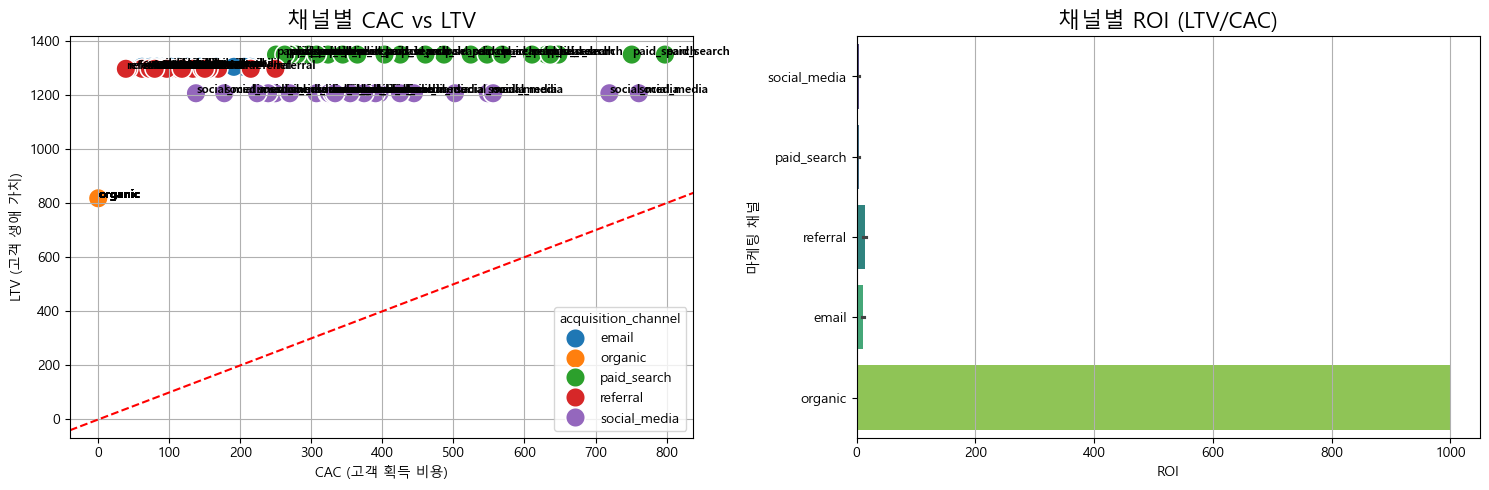

In [ ]:
# 5. 시각화 및 전략 제안 (15분)

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 5))

# CAC vs LTV 산점도 차트
plt.subplot(1, 2, 1)
sns.scatterplot(data=final_analysis_df, x='cac', y='ltv', hue='acquisition_channel', s=200)

for line in range(0, final_analysis_df.shape[0]):
    plt.text(
        final_analysis_df['cac'][line],
        final_analysis_df['ltv'][line],
        final_analysis_df['acquisition_channel'][line],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold'
    )

plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.title('채널별 CAC vs LTV', fontsize=16)
plt.xlabel('CAC (고객 획득 비용)')
plt.ylabel('LTV (고객 생애 가치)')
plt.grid(True)


# 채널별 ROI 막대 차트
# ROI가 inf인 경우 시각화를 위해 임시로 높은 값으로 변경
final_analysis_df['roi_for_plot'] = final_analysis_df['roi'].replace([np.inf], 1000)

# ROI 막대 차트
plt.subplot(1, 2, 2)
final_analysis_df_sorted = final_analysis_df.sort_values(by='roi_for_plot', ascending=True)
sns.barplot(x='roi_for_plot', y='acquisition_channel', data=final_analysis_df_sorted, palette='viridis')

plt.title('채널별 ROI (LTV/CAC)', fontsize=16)
plt.xlabel('ROI')
plt.ylabel('마케팅 채널')
plt.grid(axis='x')


# 마케팅 예산 재배분 제안 (현재 vs 최적 배분)
# 어떻게 해요? 전 모르겠읍니다.


plt.tight_layout()
plt.show()